In [3]:
#Importing Libraries
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
import pandas as pd
from nltk.tokenize import word_tokenize
import re
import string
import numpy as np
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from scipy import interp
import pickle
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Loading datas from four different domains
elec_books_pos_list=[]
elec_books_neg_list=[]
sports_toys_pos_list=[]
sports_toys_neg_list=[]
with open("elec_books_positive.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        elec_books_pos_list.append(words[i].string.strip('\n'))
    #print(list)
with open("elec_books_negative.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        elec_books_neg_list.append(words[i].string.strip('\n'))
with open("sports_toys_positive.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        sports_toys_pos_list.append(words[i].string.strip('\n'))
    #print(list)
with open("sports_toys_negative.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        sports_toys_neg_list.append(words[i].string.strip('\n'))

### Data Cleaning 

In [5]:

stop_words = stopwords.words('english')
porter=PorterStemmer()

df = pd.DataFrame()

def clean_data(data):
    new=[]
    newlist=[]
    for i in data:    
        i = re.sub(r"\'m", " am", i)
        i = re.sub(r"\'ve", " have", i)
        i = re.sub(r"n\'t", " not", i)
        i = re.sub(r"\'re", " are", i)
        i = re.sub(r"\'s", " is", i)
        i = re.sub(r"\'d", " would", i)
        i = re.sub(r"\'ll", " will", i)
        i = re.sub(r"(\n+)", " ", i)
        i=i.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation))
        new.append(i.translate(table))
    for text in new:
        sentence=[]
        word_list=text.split(' ')
        for word in word_list:
            if word not in stop_words and word.isalpha():            
                sentence.append(porter.stem(word))
        newlist.append(' '.join(sentence))
    return newlist

cleanelec_books_pos_list=clean_data(elec_books_pos_list)
cleanelec_books_neg_list=clean_data(elec_books_neg_list)
elec_books_list=cleanelec_books_pos_list+cleanelec_books_neg_list


cleansports_toys_pos_list=clean_data(sports_toys_pos_list)
cleansports_toys_neg_list=clean_data(sports_toys_neg_list)
sports_toys_list=cleansports_toys_pos_list+cleansports_toys_neg_list



In [6]:
def pos_listing(cleanpos_list):
    df_pos = pd.DataFrame(cleanpos_list)
    df_pos['sentiment'] = np.ones(len(cleanpos_list))
    df_pos.columns = ['reviews', 'sentiment']
    return df_pos

def neg_listing(cleanneg_list):
    df_neg = pd.DataFrame(cleanneg_list)
    df_neg['sentiment'] = np.zeros(len(cleanneg_list))
    df_neg.columns = ['reviews', 'sentiment']
    return df_neg

dfelec_books__pos=pos_listing(cleanelec_books_pos_list)
dfelec_books__neg=neg_listing(cleanelec_books_neg_list)


dfsports_toys_pos=pos_listing(cleansports_toys_pos_list)
dfsports_toys_neg=neg_listing(cleansports_toys_neg_list)

In [7]:

df_elec_books = dfelec_books__pos.append(dfelec_books__neg,ignore_index=True)
df_sports_toys = dfsports_toys_pos.append(dfsports_toys_neg,ignore_index=True)

finaldf=df_elec_books.append(df_sports_toys,ignore_index=True)
finaldf.shape

(7996, 2)

In [8]:
finaldf.tail()

,reviews,sentiment
7991,find replac part toy daughter work realli hard...,0.0
7992,real let daughter love hors sever breyer hors ...,0.0
7993,purchas yr old son love draw scribbl excit see...,0.0
7994,consid toler patient parent come toy nois howe...,0.0
7995,expens gift purchas christma one thing daughte...,0.0


### Tokenization 

In [9]:

finallist=[]
count=0
for text in finaldf.values:
    newlist=[]
    word_list=text[0].split(' ')
    for word in word_list:       
        newlist.append(word)
    finallist.append(newlist)

In [10]:
finaldf = shuffle(finaldf)

### Train and Test data Splitting 

In [11]:
from sklearn.model_selection import train_test_split
X = finaldf['reviews']
y = finaldf['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6396,), (6396,), (1600,), (1600,))

In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

vocab_size = len(tokenizer.word_index) + 1

max_length = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
vocab_size

22072

### Vectorization 

In [14]:
from gensim.models import Word2Vec
wordlist=[]
model = Word2Vec(finallist,min_count=5,
                 window=2,
                 size=300,
                 sample=6e-5, 
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 negative=2,
                 workers=8
        )
words=list(model.wv.vocab)
print("Total vocabulary size:",len(words))
#print(words)

Total vocabulary size: 6621


In [15]:
filename="word2vec_embeddings.txt"
model.wv.save_word2vec_format(filename, binary=False)

In [16]:
import os
embeddings_index={}
f=open(os.path.join('','word2vec_embeddings.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [17]:
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if i>vocab_size:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
print(vocab_size)

22072


# LSTM model

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Masking, Activation, Input
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model

LSTM_model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True,mask_zero=True)

LSTM_model.add(embedding_layer)

LSTM_model.add(LSTM(128))

LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
print(LSTM_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         6621600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,841,377
Trainable params: 6,841,377
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history = LSTM_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = LSTM_model.evaluate(X_test, y_test, verbose=1)

C:\Users\Jithu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5116 samples, validate on 1280 samples
Epoch 1/5
5116/5116 [==============================] - 26s 5ms/step - loss: 0.6463 - accuracy: 0.6100 - val_loss: 0.4797 - val_accuracy: 0.7797
Epoch 2/5
5116/5116 [==============================] - 24s 5ms/step - loss: 0.3299 - accuracy: 0.8694 - val_loss: 0.3865 - val_accuracy: 0.8289
Epoch 3/5
5116/5116 [==============================] - 23s 5ms/step - loss: 0.1590 - accuracy: 0.9437 - val_loss: 0.4376 - val_accuracy: 0.8188
Epoch 4/5
5116/5116 [==============================] - 23s 5ms/step - loss: 0.0761 - accuracy: 0.9783 - val_loss: 0.5295 - val_accuracy: 0.8000
Epoch 5/5
1600/1600 [==============================] - 3s 2ms/step


In [21]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

def evaluate_model(X_test, y_test, model):
    # predict probabilities for test set
    _probs = model.predict(X_test, verbose=0)
    # predict crisp classes for test set
    _classes = model.predict_classes(X_test, verbose=0)
    # reduce to 1d array
    _probs = _probs[:, 0]
    _classes = _classes[:, 0]

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, _classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, _classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, _classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, _classes)
    
    fpr, tpr, _ = roc_curve(y_test, _probs)
    
    tpr_transformed = np.array([interp(mean_fpr, fpr, tpr)])
    
    # compute the area under the curve
    _auc = auc(fpr, tpr)
    
    return accuracy, precision, recall, f1, tpr_transformed,_auc

In [22]:
LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1_score, LSTM_tpr,LSTM_auc = evaluate_model(X_test, y_test, LSTM_model)
print("LSTM_accuracy: {:.5f}".format(LSTM_accuracy))
print("LSTM_precision: {:.5f}".format(LSTM_precision))
print("LSTM_recall: {:.5f}".format(LSTM_recall))
print("LSTM_f1_score: {:.5f}".format(LSTM_f1_score))

LSTM_accuracy: 0.77563
LSTM_precision: 0.77189
LSTM_recall: 0.78250
LSTM_f1_score: 0.77716


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# CNN 

In [27]:
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
CNN_model = Sequential()

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix],  trainable=True)
CNN_model.add(embedding_layer)

CNN_model.add(Conv1D(128, 5, activation='relu'))
CNN_model.add(GlobalMaxPooling1D())
CNN_model.add(Dense(1, activation='relu'))
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [28]:
print(CNN_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         6621600   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,813,857
Trainable params: 6,813,857
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history = CNN_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = CNN_model.evaluate(X_test, y_test, verbose=1)

Train on 5116 samples, validate on 1280 samples
Epoch 1/5
5116/5116 [==============================] - 10s 2ms/step - loss: 1.1840 - acc: 0.5055 - val_loss: 0.6871 - val_acc: 0.5469
Epoch 2/5
5116/5116 [==============================] - 10s 2ms/step - loss: 0.5559 - acc: 0.8341 - val_loss: 0.6460 - val_acc: 0.6297
Epoch 3/5
5116/5116 [==============================] - 10s 2ms/step - loss: 0.3550 - acc: 0.9601 - val_loss: 0.5612 - val_acc: 0.7375
Epoch 4/5
5116/5116 [==============================] - 10s 2ms/step - loss: 0.1229 - acc: 0.9799 - val_loss: 0.5790 - val_acc: 0.7406
Epoch 5/5
1600/1600 [==============================] - 1s 423us/step


In [30]:
CNN_accuracy, CNN_precision, CNN_recall, CNN_f1_score, CNN_tpr,CNN_auc = evaluate_model(X_test, y_test, CNN_model)
print("CNN_accuracy: {:.5f}".format(CNN_accuracy))
print("CNN_precision: {:.5f}".format(CNN_precision))
print("CNN_recall: {:.5f}".format(CNN_recall))
print("CNN_f1_score: {:.5f}".format(CNN_f1_score))

CNN_accuracy: 0.74750
CNN_precision: 0.77500
CNN_recall: 0.69750
CNN_f1_score: 0.73421


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# Bar Plot

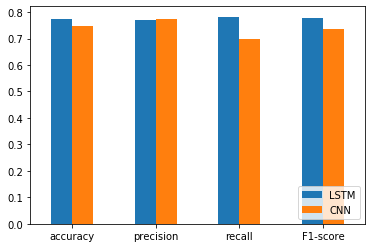

In [31]:
LSTM_metrics = np.array([LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1_score])
CNN_metrics = np.array([CNN_accuracy, CNN_precision, CNN_recall, CNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'LSTM': LSTM_metrics,'CNN': CNN_metrics }, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

# ROC Curve

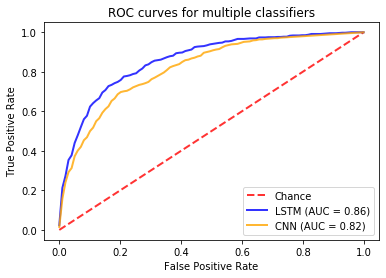

In [32]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, LSTM_tpr[0,:], lw=2, color='blue', label='LSTM (AUC = %0.2f)' % (LSTM_auc), alpha=0.8)
plt.plot(mean_fpr, CNN_tpr[0,:], lw=2, color='orange', label='CNN (AUC = %0.2f)' % (CNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

In this experiment also, LSTM provides the best performance. But comparing to the performance of single domain, the performance is low in this case even after the dataset size got increased.